### ROB 537 HW4: Project Title

1) Create a Q-learning agent that learns to solve the "Cart Pole" environment. The agent should balance the pole for 100 time steps.

    How will you handle the continuous state space?

 

2) Evolve a neural network to solve the previous task.

    What will you use for your evaluation function?

    What mapping should the network learn?

 

Evaluate & report the following:

- Answers to previous questions
- Performance over time curves for each experiment. 
- A description of your algorithms.
- Similarities and differences in performance for the two algorithms + an explanation.
 

 

Extra-Credit Bonus: Use these two learning methods to solve another gym task. Choose your favorite environment from either the "Classic Control" or "Box2D" sets.

- What environment did you choose?
- What changes did you have to make to adapt your learning algorithms to this new environment?

In [232]:
# Imports
import gymnasium as gym
import torch
import torch.nn as nn
from torch.optim import Adam
import numpy as np
import random
from collections import defaultdict, deque
import copy

import matplotlib.pyplot as plt

from tqdm import tqdm

from time import sleep

#### Part 1: Solved with DQN

Define DQN Agent

In [283]:
"""Agent Class based off BlackjackAgent from https://gymnasium.farama.org/tutorials/training_agents/blackjack_tutorial/"""

"""
Modified to make into DQN using following references:
- [1] https://blog.gofynd.com/building-a-deep-q-network-in-pytorch-fa1086aa5435 - cartpole-specific (beefed-up)
- https://gibberblot.github.io/rl-notes/single-agent/function-approximation.html - example using street crossing thing

"""

#TODO: This should work for regular Q-Learning, now make into DQN


class DQN_CartPole_Agent:

    """Generate new DQN_CartPole_Agent in environment env, with training params"""
    """Also initializes q_network"""
    def __init__(
                self,
                env,
                initial_epsilon: float,
                epsilon_decay: float,
                final_epsilon: float,
                sync_freq,
                exp_replay_size,
                discount_factor: float=0.95,
                hidden_dim=64,
                alpha=0.001,
            ):
        
        self.env = env

        self.discount_factor = torch.tensor(discount_factor) # gamma -  self.gamma = torch.tensor(0.95).float()

        # epsilon-greedy values
        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon

        # == NNs Setup ==
       
        # initialize NN # from gibberblot.github.io
        # this network is trained to output 
        # q_network takes in a state as input and returns list of Q vals for all actions available from that state
        self.q_network = nn.Sequential(
            nn.Linear(in_features=self.env.observation_space.shape[0], out_features=hidden_dim),
            nn.ReLU(),
            nn.Linear(in_features=hidden_dim, out_features=hidden_dim),
            nn.ReLU(),
            nn.Linear(in_features=hidden_dim, out_features=hidden_dim),
            nn.ReLU(),
            nn.Linear(in_features=hidden_dim, out_features=self.env.action_space.n)
        )
        self.loss_fn = nn.MSELoss()
        self.optimizer = Adam(self.q_network.parameters(), lr=alpha)

        # == Second NN "Target Network" to increase training stability ==
        # See [1]
        self.target_network = copy.deepcopy(self.q_network)

        # for synchronizing target with q_network
        self.network_sync_freq = sync_freq
        self.network_sync_counter = 0

        # == Replay buffer to address catastrophic forgetting ==
        # "The agent will gather the experience in replay buffer and then a random batch of experience will be sampled from this buffer. [1]"
        self.experience_replay = deque(maxlen = exp_replay_size)


    """ Returns the best action with probability (1 - epsilon), otherwise return random action """
    def get_action(self, obs) -> int:
        # with probability epsilon return a random action to explore the environment
        if np.random.random() < self.epsilon:
            return self.env.action_space.sample()
        # with probability (1 - epsilon) act greedily (exploitation)
        else:
            with torch.no_grad():
                Q_vals = self.q_network(torch.tensor(obs).float())
            Q_max, action = torch.max(Q_vals, dim=0)
            return action.item()
    
    # We never want to train target network, only update periodically to match q_net
    def get_q_next(self, obs):
        with torch.no_grad():
            Q_vals_next = self.target_network(torch.tensor(obs).float())
        Q_max_next, action = torch.max(Q_vals_next, dim=1)
        return Q_max_next

    def collect_experience(self, experience):
        self.experience_replay.append(experience)
        return

    def sample_from_experience(self, sample_size):
        if(len(self.experience_replay) < sample_size):
            sample_size = len(self.experience_replay)

        sample = random.sample(self.experience_replay, sample_size)

        obs = [exp[0] for exp in sample]
        action = [exp[1] for exp in sample]
        rew = [exp[2] for exp in sample]
        obs_next = [exp[3] for exp in sample]
        terminated = [exp[4] for exp in sample]
        
        return obs, action, rew, obs_next, terminated


    """In train() function, the Q-value of the current state is estimated 
    using Main Q-Network. The Q-value of the next state is calculated using 
    Target Network, which is then used to calculate the target return.
    - from blog.gofynd.com article"""
    def train(self, batch_size):

        obs, action, reward, obs_next, terminate = self.sample_from_experience(sample_size = batch_size)

        state_batch = torch.Tensor(obs)
        action_batch = torch.LongTensor(action).unsqueeze(1)
        reward_batch = torch.Tensor(reward)
        next_state_batch = torch.Tensor(obs_next)
        done_batch = terminate

        pred_q = self.q_network(state_batch).gather(1, action_batch)

        next_state_q_vals = torch.zeros(batch_size)

        for idx, next_state in enumerate(next_state_batch):
            if done_batch[idx] == True:
                next_state_q_vals[idx] = -1
            else:
                # .max in pytorch returns (values, idx), we only want vals
                next_state_q_vals[idx] = (self.target_network(next_state_batch[idx]).max(0)[0]).detach()


        better_pred = (reward_batch + next_state_q_vals).unsqueeze(1)

        loss = nn.functional.smooth_l1_loss(pred_q, better_pred)
        self.optimizer.zero_grad()
        loss.backward()
        for param in self.q_network.parameters():
            param.grad.data.clamp_(-1, 1)
        self.optimizer.step()
        return loss.item()

        '''
        # Enforce that same actions are taken for prediction
        action = torch.tensor(action)
        one_hot_encode = torch.zeros(len(action), 2)
        one_hot_encode.scatter_(1, action.unsqueeze(-1), 1)
        one_hot_encode = one_hot_encode.bool()

        # if sync counter is done, sync networks & reset counter
        #if(self.network_sync_counter == self.network_sync_freq):
        #    self.target_network.load_state_dict(self.q_network.state_dict())
        #    self.network_sync_counter = 0
        
        # predict expected return of current state using main network
        Q_Vals = self.q_network(torch.tensor(obs).float())
            # predicted return from taking recorded action
        pred_return = Q_Vals[one_hot_encode] #torch.max(Q_Vals, axis=1)
        
        # get target return using target network
        Q_vals_next = self.get_q_next(obs_next)
            # "actual/best" return possible - return is always 1
        target_return = torch.tensor(reward).float() + self.discount_factor * Q_vals_next # * (1-terminate)
        #print('Discounted Q_next: ', self.discount_factor * Q_vals_next[0])
        #print('Pred Ret: ', pred_return, '\nTarg Ret: ', target_return, '\nLoss: ', self.loss_fn(pred_return, target_return))
        
        loss = nn.functional.smooth_l1_loss(pred_return, target_return) #self.loss_fn(pred_return, target_return)
        self.optimizer.zero_grad()
        loss.backward() # retain_graph=True)
        self.optimizer.step()
        
        #self.network_sync_counter += 1      

        return loss.item()
        '''

    def sync_networks(self):
        self.target_network.load_state_dict(self.q_network.state_dict())

    """Call during training to decrease probability of exploration over time"""
    def decay_epsilon(self):
        self.epsilon = max(self.final_epsilon, self.epsilon - self.epsilon_decay)

Define (or do?) Training & Validation

100%|██████████| 10000/10000 [47:20<00:00,  3.52it/s]


0:  764947 1:  754978


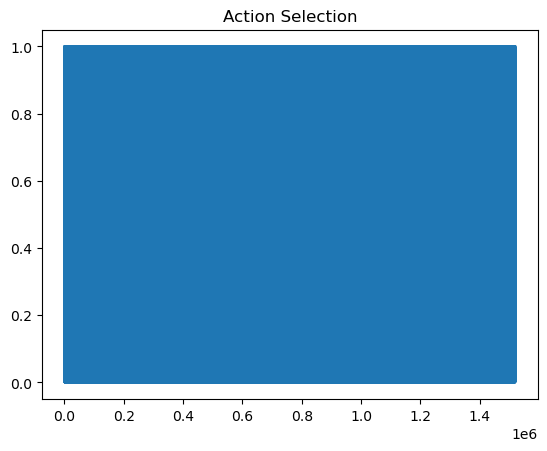

In [290]:
EPISODES = 10000
start_epsilon = 1.0
epsilon_decay = start_epsilon / (EPISODES/1.5)
final_epsilon = 0.05
sync_freq = 1000
exp_replay_size = 60000

# Init environment & agent
env = gym.make('CartPole-v1')
dqn_agent = DQN_CartPole_Agent(env, start_epsilon, epsilon_decay, final_epsilon, sync_freq, exp_replay_size, alpha = 0.0001)

# == Fill replay buffer to capacity ==
# Full exploration at this time - no epsilon decay
index = 0
for i in range(exp_replay_size):
    obs, info = env.reset()
    done = False
    while not done:
        action = dqn_agent.get_action(obs)
        obs_next, reward_gained, done, truncated, info = env.step(action)
        dqn_agent.collect_experience([obs, action, reward_gained, obs_next, done])
        
        obs = obs_next

        # timeout tracker
        index += 1
        if index > exp_replay_size:
            break


# === MAIN TRAINING ===
index = exp_replay_size / 2

# Performance trackers
track_loss = []
track_reward = []
track_episode_len = []
track_epsilon = []

cum0 = 0
cum1 = 0
track_act = []

for i in tqdm(range(EPISODES)):
    obs, info = env.reset()
    done = False
    truncated = False
    reward_gained = 0
    losses = 0
    episode_len = 0

    # periodically synchronize networks
    if i % sync_freq == 0:
        dqn_agent.sync_networks()

    while not done and not truncated:
        
        # Make action, collect reward
        action = dqn_agent.get_action(obs)

        if action == 0:
            cum0 += 1
        else:
            cum1 += 1
        track_act.append(action)
            
        obs_next, reward, done, truncated, info = env.step(action)
        dqn_agent.collect_experience([obs, action, reward, obs_next, done])

        # Update bookkeeping
        obs = obs_next
        reward_gained += reward
        episode_len += 1
        index += 1

        # Agent interacts with environment & fills experience into buffer
        # then periodically trains by sampling this experience here
        if index > 128:
            index = 0

            # do training steps, training on randomly sampled batches
            for j in range(4):
                loss = dqn_agent.train(batch_size=128)
                losses += loss

    dqn_agent.decay_epsilon()

    # Performance tracking
    track_loss.append(losses/episode_len)
    track_reward.append(reward_gained)
    track_episode_len.append(episode_len)
    track_epsilon.append(dqn_agent.epsilon)

print('0: ', cum0, '1: ', cum1)

plt.plot(track_act)
plt.title('Action Selection')
plt.show()


Evaluate Results

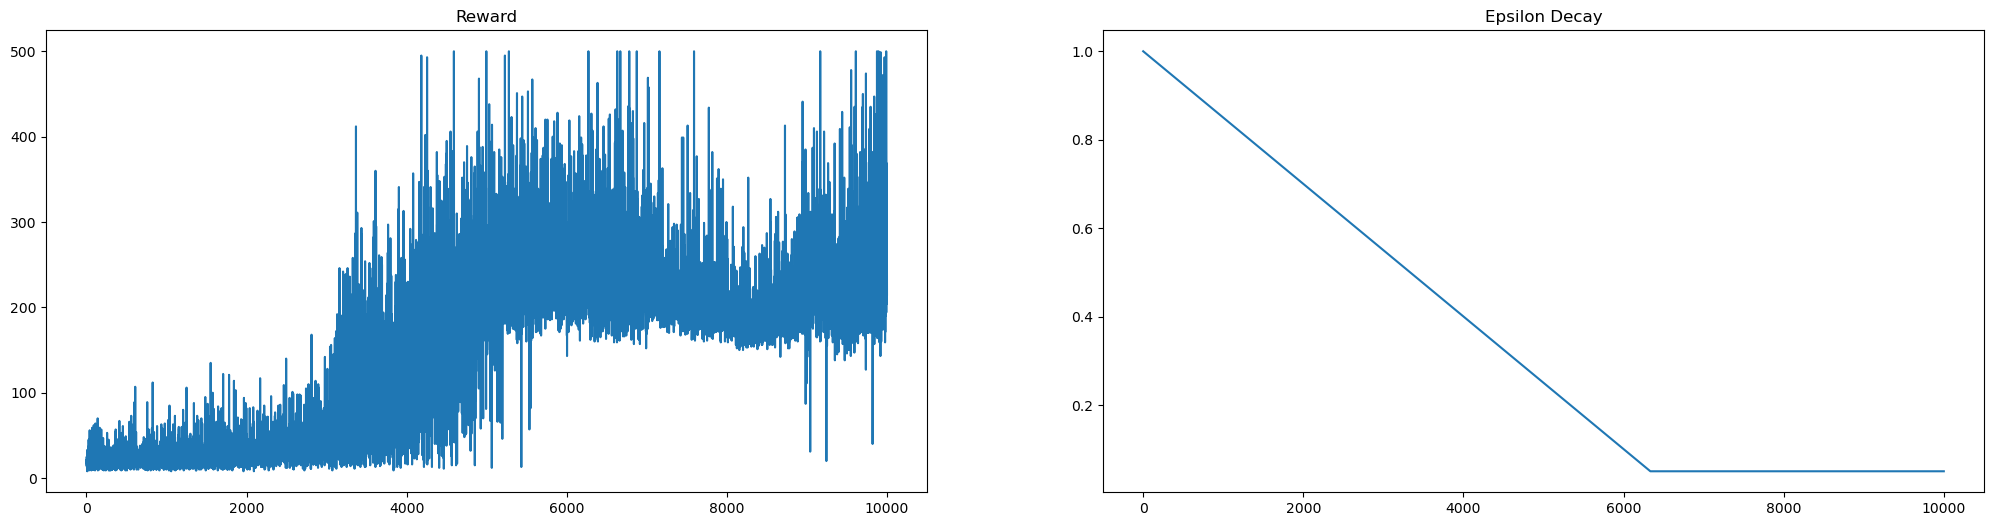

In [297]:

fig, axes = plt.subplots(1,2, figsize = (25,6))

#axes[0].plot(track_loss)
#axes[0].set_title('Loss')

axes[0].plot(track_reward)
axes[0].set_title('Reward')

#axes[2].plot(track_episode_len)
#axes[2].set_title('Episode Length')

axes[1].plot(track_epsilon)
axes[1].set_title('Epsilon Decay')

plt.show()

Episode 0 finished after 28 timesteps
Avg Loss:  0.0
0.994694868233018
Episode 1 finished after 12 timesteps
Avg Loss:  0.0
Episode 2 finished after 14 timesteps
Avg Loss:  0.0
Episode 3 finished after 14 timesteps
Avg Loss:  0.0
Episode 4 finished after 12 timesteps
Avg Loss:  0.0
Episode 5 finished after 17 timesteps
Avg Loss:  0.0
Episode 6 finished after 18 timesteps
Avg Loss:  0.0
Episode 7 finished after 18 timesteps
Avg Loss:  0.16647772159841326
Episode 8 finished after 14 timesteps
Avg Loss:  0.4902978539466858
Episode 9 finished after 23 timesteps
Avg Loss:  0.4810166488523069
Episode 10 finished after 14 timesteps
Avg Loss:  0.4701122726712908
Episode 11 finished after 15 timesteps
Avg Loss:  0.46613884369532266
Episode 12 finished after 9 timesteps
Avg Loss:  0.4561401175128089
Episode 13 finished after 9 timesteps
Avg Loss:  0.44856329096688163
Episode 14 finished after 50 timesteps
Avg Loss:  0.4281056642532349
Episode 15 finished after 22 timesteps
Avg Loss:  0.403874547

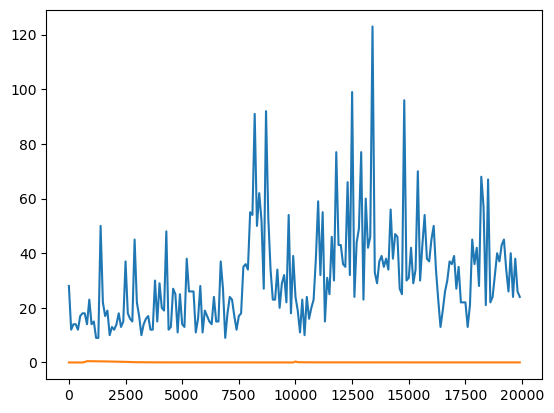

In [278]:
"""FROM: https://stackoverflow.com/questions/56964657/cartpole-v0-loss-increasing-using-dqn"""
import random
import math
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.nn.functional as F
import gymnasium as gym

class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.linear1 = nn.Linear(input_dim, 16)
        self.linear2 = nn.Linear(16, 32)
        self.linear3 = nn.Linear(32, 32)
        self.linear4 = nn.Linear(32, output_dim)


    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = F.relu(self.linear3(x))
        return self.linear4(x)


final_epsilon = 0.05
initial_epsilon = 1
epsilon_decay = 5000
global steps_done
steps_done = 0


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = final_epsilon + (initial_epsilon - final_epsilon) * \
                    math.exp(-1. * steps_done / epsilon_decay)
    if sample > eps_threshold:
        with torch.no_grad():
            state = torch.Tensor(state)
            steps_done += 1
            q_calc = model(state)
            node_activated = int(torch.argmax(q_calc))
            return node_activated
    else:
        node_activated = random.randint(0,1)
        steps_done += 1
        return node_activated


class ReplayMemory(object): # Stores [state, reward, action, next_state, done]

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = [[],[],[],[],[]]

    def push(self, data):
        """Saves a transition."""
        for idx, point in enumerate(data):
            #print("Col {} appended {}".format(idx, point))
            self.memory[idx].append(point)

    def sample(self, batch_size):
        rows = random.sample(range(0, len(self.memory[0])), batch_size)
        experiences = [[],[],[],[],[]]
        for row in rows:
            for col in range(5):
                experiences[col].append(self.memory[col][row])
        return experiences

    def __len__(self):
        return len(self.memory[0])


input_dim, output_dim = 4, 2
model = DQN(input_dim, output_dim)
target_net = DQN(input_dim, output_dim)
target_net.load_state_dict(model.state_dict())
target_net.eval()
tau = 100
discount = 0.99

learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

memory = ReplayMemory(65536)
BATCH_SIZE = 128


def optimize_model():
    if len(memory) < BATCH_SIZE:
        return 0
    experiences = memory.sample(BATCH_SIZE)
    state_batch = torch.Tensor(experiences[0])
    action_batch = torch.LongTensor(experiences[1]).unsqueeze(1)
    reward_batch = torch.Tensor(experiences[2])
    next_state_batch = torch.Tensor(experiences[3])
    done_batch = experiences[4]

    pred_q = model(state_batch).gather(1, action_batch)

    next_state_q_vals = torch.zeros(BATCH_SIZE)

    for idx, next_state in enumerate(next_state_batch):
        if done_batch[idx] == True:
            next_state_q_vals[idx] = -1
        else:
            # .max in pytorch returns (values, idx), we only want vals
            next_state_q_vals[idx] = (target_net(next_state_batch[idx]).max(0)[0]).detach()


    better_pred = (reward_batch + next_state_q_vals).unsqueeze(1)

    loss = F.smooth_l1_loss(pred_q, better_pred)
    optimizer.zero_grad()
    loss.backward()
    for param in model.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()
    return loss


points = []
losspoints = []

#save_state = torch.load("models/DQN_target_11.pth")
#model.load_state_dict(save_state['state_dict'])
#optimizer.load_state_dict(save_state['optimizer'])



env = gym.make('CartPole-v1')
for i_episode in range(200):
    observation, info = env.reset()
    episode_loss = 0
    if i_episode % tau == 0:
        target_net.load_state_dict(model.state_dict())
    for t in range(1000):
        #env.render()
        state = observation
        action = select_action(observation)
        observation, reward, done, _, _ = env.step(action)

        if done:
            next_state = [0,0,0,0]
        else:
            next_state = observation

        memory.push([state, action, reward, next_state, done])
        episode_loss = episode_loss + float(optimize_model())
        if done:
            points.append((i_episode, t+1))
            print("Episode {} finished after {} timesteps".format(i_episode, t+1))
            print("Avg Loss: ", episode_loss / (t+1))
            losspoints.append((i_episode, episode_loss / (t+1)))
            if (i_episode % 100 == 0):
                eps = final_epsilon + (initial_epsilon - final_epsilon) * \
                    math.exp(-1. * steps_done / epsilon_decay)
                print(eps)
            if ((i_episode+1) % 5001 == 0):
                save = {'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict()}
                torch.save(save, "models/DQN_target_" + str(i_episode // 5000) + ".pth")
            break
env.close()




x = [coord[0] * 100 for coord in points]
y = [coord[1] for coord in points]

x2 = [coord[0] * 100 for coord in losspoints]
y2 = [coord[1] for coord in losspoints]

plt.plot(x, y)
plt.plot(x2, y2)
plt.show()

#### Part 2: Solved with Neurocontrol Strategy

2) Evolve a neural network to solve the previous task.

    What will you use for your evaluation function?

    What mapping should the network learn?

 

Evaluate & report the following:

- Answers to previous questions
- Performance over time curves for each experiment. 
- A description of your algorithms.
- Similarities and differences in performance for the two algorithms + an explanation.

In [ ]:

# Define DQN Agent, with only q-network (no target network)




# === Training ===

# Initialize a population of k DQN_Agents


# for i training epochs:

    # == Generate Successors & Mutate ==
    # for each DQN_Agnet, create a copy and perform some mutation to the copy


    # == Evaluate ==
    # for each DQN_Agent, perform simulation n times & sum all rewards (rewards are fitness)


    # == Select ==
    # To begin, let's just select the k best-performing DQN_Agents


    # == Repeat ==

In [12]:
"""CARTPOLE NOTES"""

""" ACTION SPACE
The action is a ndarray with shape (1,) which can take values {0, 1} indicating the direction of the fixed force the cart is pushed with.
0: Push cart to the left
1: Push cart to the right
"""

""" OBSERVATION SPACE
The observation is a ndarray with shape (4,) with the values corresponding to the following positions and velocities:
0: Cart Position (-4.8, 4.8)
1: Cart Velocity (-Inf, Inf)
2: Pole Angle (~ -0.418 rad (-24°), ~ 0.418 rad (24°))
3: Pole Angular Velocity (-Inf, Inf)

Note: While the ranges above denote the possible values for observation space of each element, it is not reflective of the allowed 
values of the state space in an unterminated episode. Particularly:
- The cart x-position (index 0) can be take values between (-4.8, 4.8), but the episode terminates if the cart leaves the (-2.4, 2.4) range.
- The pole angle can be observed between (-.418, .418) radians (or ±24°), but the episode terminates if the pole angle is not in the 
range (-.2095, .2095) (or ±12°)
"""

""" REWARDS
Since the goal is to keep the pole upright for as long as possible, a reward of +1 for every step taken, including the termination step,
is allotted. The threshold for rewards is 500 for v1 and 200 for v0.
"""

' REWARDS\nSince the goal is to keep the pole upright for as long as possible, a reward of +1 for every step taken, including the termination step,\nis allotted. The threshold for rewards is 500 for v1 and 200 for v0.\n'